In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

In [2]:
x_train = np.linspace(-3, 3, 10)[:, None]
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=x_train.shape)

In [3]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter(), self.set_prior_dist():
            self.w1_mu = np.zeros((n_input, n_hidden))
            self.w1_s = np.zeros((n_input, n_hidden))
            self.b1_mu = np.zeros(n_hidden)
            self.b1_s = np.zeros(n_hidden)
            self.w2_mu = np.zeros((n_hidden, n_output))
            self.w2_s = np.zeros((n_hidden, n_output))
            self.b2_mu = np.zeros(n_output)
            self.b2_s = np.zeros(n_output)
            self.prior = bn.random.Gaussian(0, 1)

    def __call__(self, x, y=None):
        self.qw1 = bn.random.Gaussian(
            self.w1_mu, bn.softplus(self.w1_s),
            p=self.prior
        )
        self.qb1 = bn.random.Gaussian(
            self.b1_mu, bn.softplus(self.b1_s),
            p=self.prior
        )
        self.qw2 = bn.random.Gaussian(
            self.w2_mu, bn.softplus(self.w2_s),
            p=self.prior
        )
        self.qb2 = bn.random.Gaussian(
            self.b2_mu, bn.softplus(self.b2_s),
            p=self.prior
        )
        h = bn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        mu = h @ self.qw2.draw() + self.qb2.draw()
        self.py = bn.random.Gaussian(mu, 0.1, data=y)
        if y is None:
            return self.py.draw().value

In [4]:
model = BayesianNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

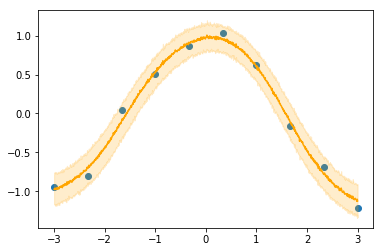

In [5]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
y = [model(x) for _ in range(100)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.plot(x, y_mean, c="orange")
plt.fill_between(x.ravel(), (y_mean - y_std).ravel(), (y_mean + y_std).ravel(), color="orange", alpha=0.2)
plt.show()

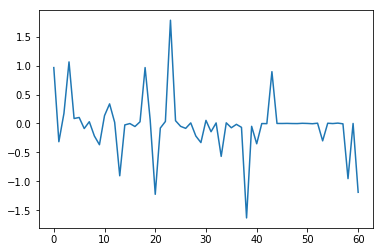

In [6]:
parameter = []
parameter.extend(list(model.w1_mu.value.ravel()))
parameter.extend(list(model.b1_mu.value.ravel()))
parameter.extend(list(model.w2_mu.value.ravel()))
parameter.extend(list(model.b2_mu.value.ravel()))
plt.plot(parameter)

In [7]:
class ARDNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter(), self.set_prior_dist():
            self.ptau = bn.random.Gamma(1, 1e-2)
            self.qtauw1_shape = np.ones((n_input, n_hidden))
            self.qtauw1_rate = np.ones((n_input, n_hidden))

            self.qw1_mu = np.zeros((n_input, n_hidden))
            self.qw1_s = np.zeros((n_input, n_hidden))

            self.qtaub1_shape = np.ones(n_hidden)
            self.qtaub1_rate = np.ones(n_hidden)

            self.qb1_mu = np.ones(n_hidden)
            self.qb1_s = np.ones(n_hidden)

            self.qtauw2_shape = np.ones((n_hidden, n_output))
            self.qtauw2_rate = np.ones((n_hidden, n_output))

            self.qw2_mu = np.zeros((n_hidden, n_output))
            self.qw2_s = np.zeros((n_hidden, n_output))

            self.qtaub2_shape = np.ones(n_output)
            self.qtaub2_rate = np.ones(n_output)

            self.qb2_mu = np.ones(n_output)
            self.qb2_s = np.ones(n_output)

    def __call__(self, x, y=None):
        self.qtauw1 = bn.random.Gamma(
            shape=bn.softplus(self.qtauw1_shape),
            rate=bn.softplus(self.qtauw1_rate),
            p=self.ptau
        )
        pw1 = bn.random.Gaussian(mu=0, tau=self.qtauw1.draw())
        self.qw1 = bn.random.Gaussian(
            mu=self.qw1_mu,
            std=bn.softplus(self.qw1_s),
            p=pw1
        )

        self.qtaub1 = bn.random.Gamma(
            shape=bn.softplus(self.qtaub1_shape),
            rate=bn.softplus(self.qtaub1_rate),
            p=self.ptau
        )
        pb1 = bn.random.Gaussian(mu=0, tau=self.qtaub1.draw())
        self.qb1 = bn.random.Gaussian(
            mu=self.qb1_mu,
            std=bn.softplus(self.qb1_s),
            p=pb1
        )

        self.qtauw2 = bn.random.Gamma(
            shape=bn.softplus(self.qtauw2_shape),
            rate=bn.softplus(self.qtauw2_rate),
            p=self.ptau
        )
        pw2 = bn.random.Gaussian(mu=0, tau=self.qtauw2.draw())
        self.qw2 = bn.random.Gaussian(
            mu=self.qw2_mu,
            std=bn.softplus(self.qw2_s),
            p=pw2
        )

        self.qtaub2 = bn.random.Gamma(
            shape=bn.softplus(self.qtaub2_shape),
            rate=bn.softplus(self.qtaub2_rate),
            p=self.ptau
        )
        pb2 = bn.random.Gaussian(mu=0, tau=self.qtaub2.draw())
        self.qb2 = bn.random.Gaussian(
            mu=self.qb2_mu,
            std=bn.softplus(self.qb2_s),
            p=pb2
        )

        h = bn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        mu = h @ self.qw2.draw() + self.qb2.draw()
        self.py = bn.random.Gaussian(mu, 0.1, data=y)
        if y is None:
            return self.py.draw().value

In [8]:
model = ARDNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

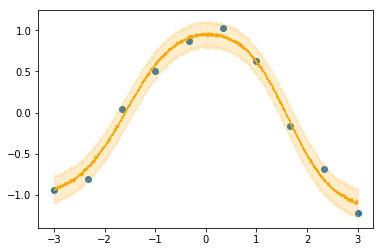

In [9]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
y = [model(x) for _ in range(100)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.plot(x, y_mean, c="orange")
plt.fill_between(x.ravel(), (y_mean - y_std).ravel(), (y_mean + y_std).ravel(), color="orange", alpha=0.2)
plt.show()

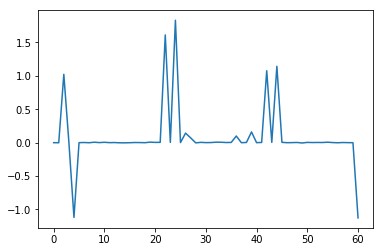

In [10]:
parameter = []
parameter.extend(list(model.qw1_mu.value.ravel()))
parameter.extend(list(model.qb1_mu.value.ravel()))
parameter.extend(list(model.qw2_mu.value.ravel()))
parameter.extend(list(model.qb2_mu.value.ravel()))
plt.plot(parameter)